# Multinomial regression

In this notebook we perform multinomial / softmax resression

### Import functions

In [2]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from Code.utilities import cross_entropy_loss_method, predict, accuracy_func_method
from Code.descent_methods import SGD_adam
from Code.data_handling import load_MNIST_28, append_run_to_file, load_run_from_file
from Code.softmax_regression import softmax_beta_init, softmax_model
from Code.plot import *

from jax import jit, nn, grad
import numpy as np
import matplotlib.pyplot as plt

# Set the default font size for text elements (e.g., titles, labels)
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download the data

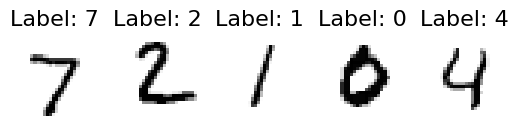

In [3]:
# download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=True)

# Display some images
plot_some_imgs(X_test, y_test)

### Single run

100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


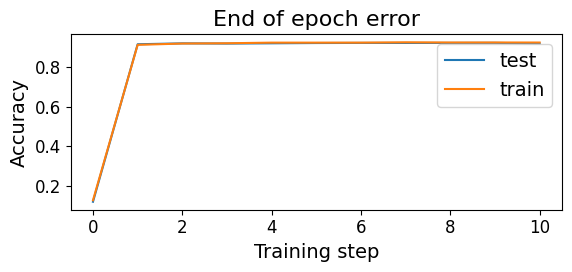

test:  0.9211999773979187
train:  0.9265333414077759
CE test:  0.9212
CE train:  0.92653334


In [4]:
def single_run(X_train, X_test, y_train, y_test, 
               lr, lam, epochs=300, batch_size=32, 
               plot_or_not=False, result_filepath=None, store_params=False, 
               test_func_and_name=(cross_entropy_loss_method, "CE"), 
               intermediate_epochs=None):
    
    """
    Performs a training with the given parameters

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    beta0 = softmax_beta_init(input_shape=X_train.shape[1], output_shape=y_train.shape[1])
    model = softmax_model

    # Create gradient from loss function. Also get the accuracy function. lam=0 gives MSE
    loss_func = jit(cross_entropy_loss_method(model=model, lam=lam))
    loss_grad = jit(grad(loss_func))
    accuracy_func = jit(accuracy_func_method(model))

    # (usually MSE) loss function for evaluation
    if plot_or_not:
        test_func = jit(test_func_and_name[0](model))
    else:
        test_func = None

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, 
                      grad_method=loss_grad,beta0=beta0, 
                      n_epochs=epochs, batch_size=batch_size,
                      test_loss_func= test_func, lr=lr, 
                      intermediate_epochs=intermediate_epochs)

    # Plot if wanted ...
    if plot_or_not:
        plot_test_results(result["test_loss_list"], result["train_loss_list"], ylabel=test_func_and_name[1])

    # Add accuracy scores
    result["test_accuracy"]  = float(accuracy_func(result["beta_final"], X_test, y_test))
    result["train_accuracy"] = float(accuracy_func(result["beta_final"], X_train, y_train))
    # Also store the model for potential later use
    result["model"] = model

    # Store the result to given file
    if result_filepath:

        # Possibility of storing run with fewer epochs
        if intermediate_epochs is not None:
            for ie, be in zip(intermediate_epochs, result["beta_intermediate"]):
                _dict_to_store = {"test_accuracy"     : float(accuracy_func(be, X_test, y_test)), 
                                  "train_accuracy"    : float(accuracy_func(be, X_train, y_train)),
                                  "lr"                : lr, 
                                  "lam"               : lam,
                                  "epochs"            : ie,
                                  "batch_size"        : batch_size,
                                  "train_num"         : y_train.shape[0],
                                   "test_num"          : y_test.shape[0]}

                append_run_to_file(result_filepath, _dict_to_store)

        _dict_to_store = {"test_accuracy"     : result["test_accuracy"], 
                          "train_accuracy"    : result["train_accuracy"],
                          "lr"                : lr, 
                          "lam"               : lam,
                          "epochs"            : epochs,
                          "batch_size"        : batch_size,
                          "train_num"         : y_train.shape[0],
                          "test_num"          : y_test.shape[0]}
        if store_params:
            _dict_to_store["beta_final"] = {key: value.tolist() for key, value in result["beta_final"].items()}
        append_run_to_file(result_filepath, _dict_to_store)

    return result

## A demonstration
epochs = 10
batch_size = 128
lr = 0.005 
result = single_run(X_train, X_test, y_train, y_test, 
                    lr=lr, lam=0.0001, epochs=epochs, batch_size=batch_size,
                    plot_or_not=True, test_func_and_name=(accuracy_func_method, "Accuracy"), 
                    result_filepath="test.json")

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

print("CE test: ", result["test_loss_list"][-1])
print("CE train: ", result["train_loss_list"][-1])

### Tuning the learning rate, batch size and epoch number

In [5]:
def run_experiment():
    batch_sizes           = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
    learning_rates        = [0.1, 0.05, 0.02, 0.01, 0.005, 0.001]
    regularisation_params = [0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

    # We do one run with max epoch number, storing the intermediate as their own runs
    epoch_numbers = [2, 5, 8, 10, 15, 20, 35, 50]

    # Path to result
    result_filepath = "Results/multinomial_28.json"

    # Perform the #b*#l*#e experiments
    for r in regularisation_params:
        for l in learning_rates:
            for b in batch_sizes:
                print(f"Batch Size: {b}, Learning Rate: {l}, Regularisation: {r}")

                result = single_run(X_train, X_test, y_train, y_test, 
                                    lr=l, lam=r, epochs=epoch_numbers[-1], batch_size=b,
                                    plot_or_not=False, result_filepath=result_filepath, intermediate_epochs=epoch_numbers[0:-1])
                
# run_experiment()

c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\Code\plot.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


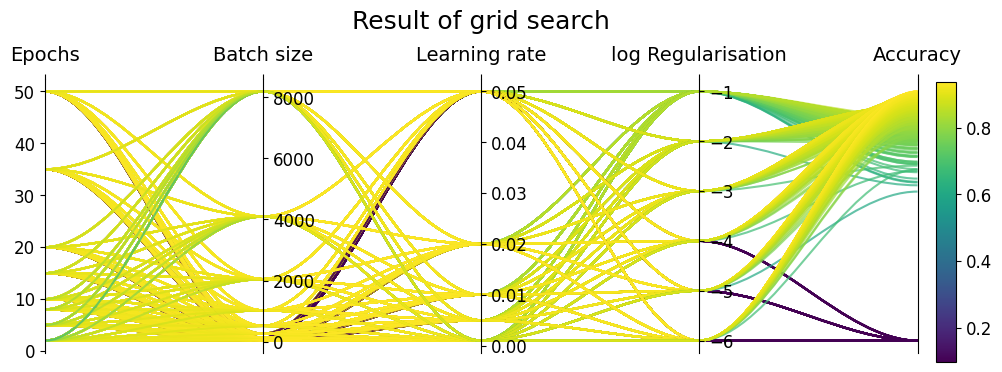

In [12]:
run_list = load_run_from_file("Results/multinomial_28.json")


data = {
    "Epochs": [],
    "Batch size": [],
    "Learning rate": [],
    "log Regularisation": [],
    "Accuracy": [],
}

for run in run_list:

    if run["lr"] < 0.1:#0.92:

        ## TODO HANDLE
        if run["lam"] > 0:

            data["Epochs"].append(run["epochs"])
            data["Batch size"].append(run["batch_size"])
            data["Learning rate"].append(run["lr"])
            data["log Regularisation"].append(np.log10(run["lam"]))
            data["Accuracy"].append(run["train_accuracy"])

plot_grid_search_result(data)


### Final model evaluation

In [8]:
l = 0.01
e = 100
b = 64

result = single_run(X_train, X_test, y_train, y_test, 
                    lr=l, lam=0.0001, epochs=e, batch_size=b,
                    plot_or_not=False, result_filepath="test.json")

model = result["model"]
beta = result["beta_final"]

100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


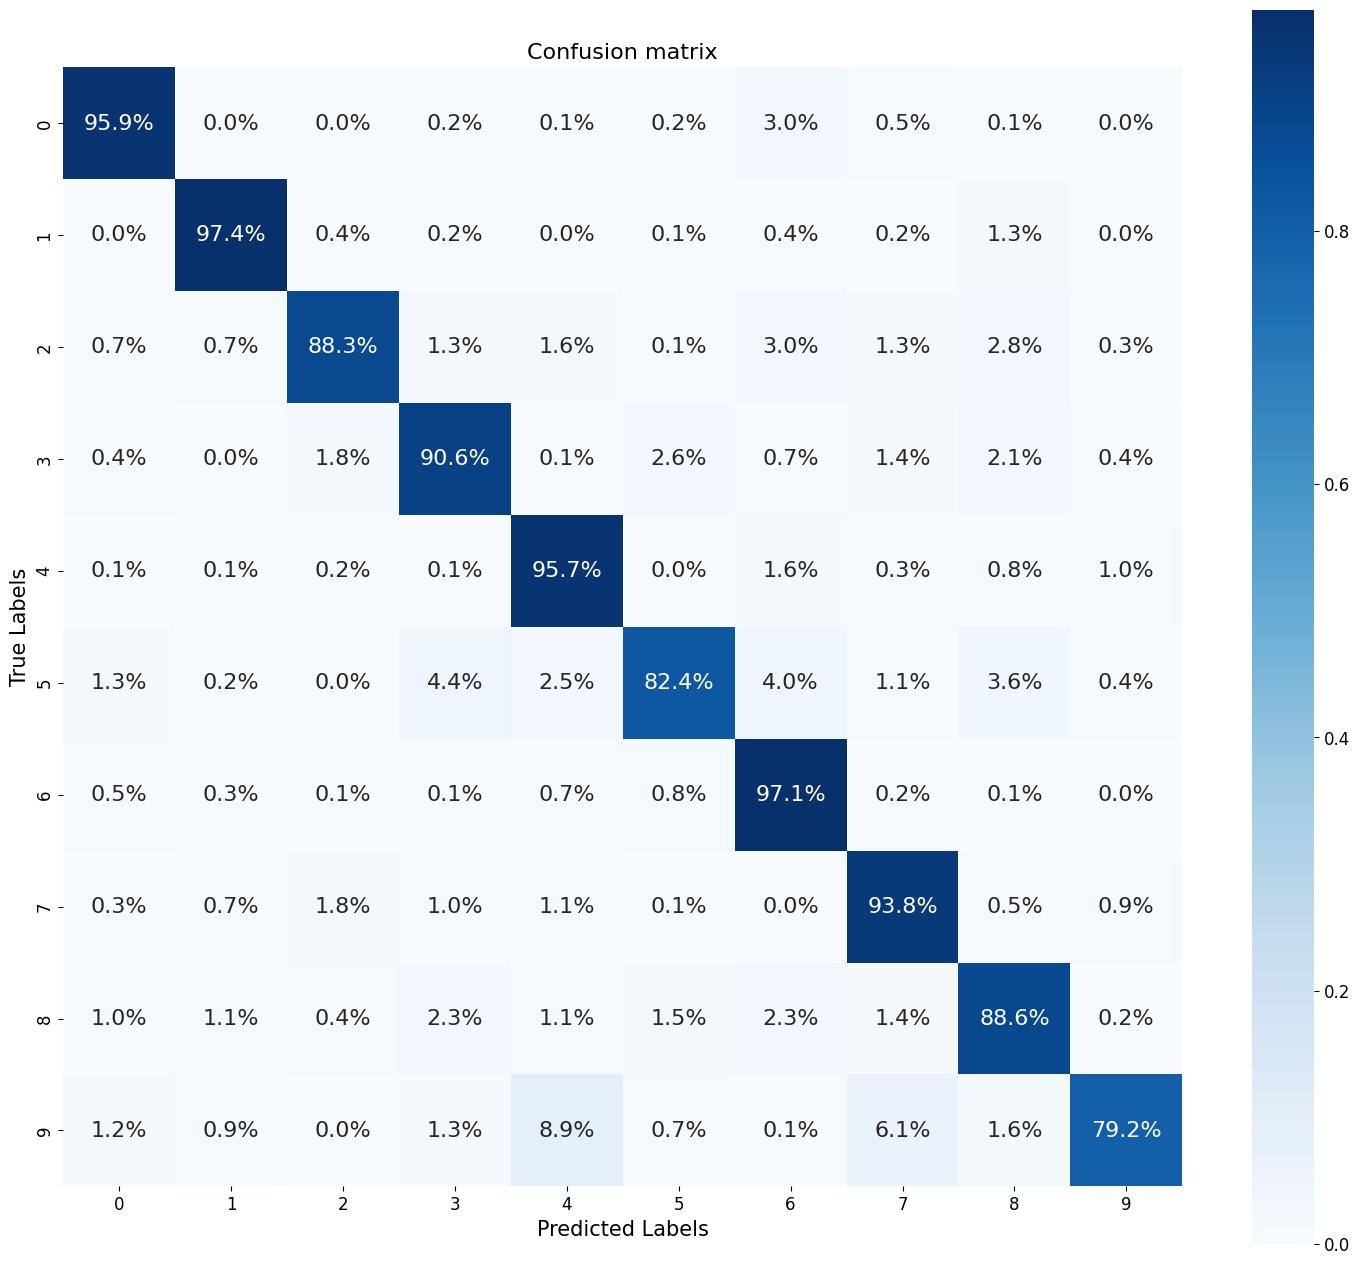

In [9]:
def plot_confusion_matrix(X_test, y_test, model, beta, filename=None, 
                          convert_to_percent=False, title="Confusion matrix",
                          fontsize=15):

    # Initialise the figure
    plt.figure(figsize=(15,13))

    # Example true labels and predicted labels
    nums_pred = np.argmax(predict(model, beta, X_test), axis=1)
    nums_gt   = np.argmax(y_test, axis=1)

    # Create confusion matrix. If desired, convert to percentage
    conf_matrix = confusion_matrix(nums_gt, nums_pred)

    # Plot with or without converting to percentages
    if convert_to_percent: 
        conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
        sns.heatmap(conf_matrix, annot=True, fmt=".1%", cmap="Blues", square=True,
                    xticklabels=np.arange(10), yticklabels=np.arange(10))
    else:
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", square=True,
                    xticklabels=np.arange(10), yticklabels=np.arange(10))

    plt.xlabel("Predicted Labels", fontsize=fontsize)
    plt.ylabel("True Labels", fontsize=fontsize)
    plt.title(title)
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

plot_confusion_matrix(X_test, y_test, model, beta,
                      convert_to_percent=True, 
                      filename=filepath_location + "confusion",
                      fontsize=15) 

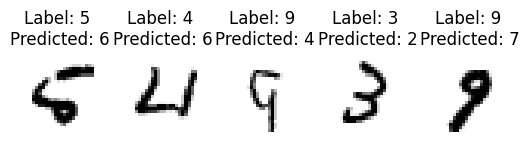

In [10]:
plot_faulty_predictions(X_test, y_test, model, beta)